In [1]:
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, AncillaRegister
from qiskit.circuit import Gate
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.animation import FuncAnimation
from typing import Any
import csv
from datetime import datetime

In [3]:
def encode(variable: NDArray[np.float64]) -> Statevector:
    concatenated = np.concatenate((variable, variable, variable, np.zeros(len(variable))))
    concatenated = concatenated / np.linalg.norm(concatenated)
    
    state = Statevector(concatenated)
    ancilla = Statevector([1.0, 0.0])

    return state.expand(ancilla)

In [4]:
def c_gate(lambdas: NDArray[np.float64]) -> Gate:
    qc = QuantumCircuit(3)
    
    qc.mcp(lambdas[0], [1,2], 0, ctrl_state='00')
    qc.mcx([1,2], 0, ctrl_state='00')
    qc.mcp(lambdas[0], [1,2], 0, ctrl_state='00')
    qc.mcx([1,2], 0, ctrl_state='00')

    qc.mcp(lambdas[1], [1,2], 0, ctrl_state='01')
    qc.mcx([1,2], 0, ctrl_state='01')
    qc.mcp(lambdas[1], [1,2], 0, ctrl_state='01')
    qc.mcx([1,2], 0, ctrl_state='01')

    qc.mcp(lambdas[2], [1,2], 0, ctrl_state='10')
    qc.mcx([1,2], 0, ctrl_state='10')
    qc.mcp(lambdas[2], [1,2], 0, ctrl_state='10')
    qc.mcx([1,2], 0, ctrl_state='10')
    
    return qc.to_gate(label='C')

In [5]:
def collision(num_qubits: int, lambdas: NDArray[np.float64]) -> QuantumCircuit:
    qc = QuantumCircuit(num_qubits)
    
    ancilla = num_qubits - 1

    qc.h(ancilla)
    qc.append(c_gate(lambdas).control(1, ctrl_state='0'), [ancilla, 0, num_qubits - 3, num_qubits - 2])
    qc.append(c_gate(-1 * lambdas).control(1, ctrl_state='1'), [ancilla, 0, num_qubits - 3, num_qubits - 2])
    qc.h(ancilla)

    return qc

In [6]:
def r_gate(num_qubits: int) -> Gate:
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits - 1, -1, -1):
        if i == 0:
            qc.x(i)
        else:
            controls = list(range(0, i))
            qc.mcx(controls, i)
    
    return qc.to_gate(label='R')

def l_gate(num_qubits: int) -> Gate:
    qc = QuantumCircuit(num_qubits)
    for i in range(num_qubits):
        if i == 0:
            qc.x(i)
        else:
            controls = list(range(0, i))
            qc.mcx(controls, i)
    
    return qc.to_gate(label='L')


In [7]:
def propagation(num_qubits: int) -> QuantumCircuit:
    qc = QuantumCircuit(num_qubits)
    
    target_qubits = list(range(num_qubits - 2))
    r_ctrl = r_gate(num_qubits - 2).control(2, ctrl_state='00')
    qc.append(r_ctrl, [num_qubits - 2, num_qubits - 1] + target_qubits)
    l_ctrl = l_gate(num_qubits - 2).control(2, ctrl_state='10')
    qc.append(l_ctrl, [num_qubits - 2, num_qubits - 1] + target_qubits)
    
    return qc

In [8]:
def macros() -> QuantumCircuit:
    qc = QuantumCircuit(3)
    
    #qc.swap(0, 1)
    qc.h(0)
    qc.h(1)
    
    return qc

In [28]:
def animate_density_evolution(filename: str, interval: int = 100, repeat: bool = False) -> FuncAnimation:
    # Read the CSV file
    df = pd.read_csv(filename)
    
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    line, = ax.plot([], [], 'b-')
    
    # Set the plot limits and labels
    ax.set_xlim(0, len(df.columns) - 1)
    ax.set_ylim(0, np.max(df.values) * 1.1)  # Set y limit to max density value
    ax.grid(True)
    ax.set_xlabel('Site')
    ax.set_ylabel('Density')
    ax.set_title('Density Evolution Animation')
    
    def init():
        line.set_data([], [])
        return line,
    
    def update(frame):
        line.set_data(range(len(df.columns)), df.iloc[frame])
        return line,
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=len(df),
                        init_func=init, blit=True,
                        interval=interval, repeat=repeat)
    
    return anim

In [30]:
num_sites = 64

dimensions = 1
velocities = [1, 0, -1]
weights = np.array([1/6, 3/6, 2/6])
speed_of_sound = 1/np.sqrt(3)
advection = 0
iterations = 50

lambdas = np.array([np.arccos(w * (1 + (v * advection)/speed_of_sound**2)) for w, v in zip(weights, velocities)])

density = np.full(num_sites, 0.1)
density[12] = 0.2
density[13] = 0.4
density[14] = 0.2

original_norm = np.linalg.norm(density)

state = encode(density)

if state.num_qubits is None:
    raise ValueError("Statevector must have a number of qubits defined.")

qc = QuantumCircuit(state.num_qubits)
qc.append(collision(state.num_qubits, lambdas), list(range(state.num_qubits)))
qc.append(propagation(state.num_qubits - 1), list(range(0, state.num_qubits - 1)))
qc.append(macros(), [state.num_qubits - 3, state.num_qubits - 2, state.num_qubits - 1])

# Create unique filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"experiments/density_evolution_{timestamp}.csv"

# Initialize CSV file with headers
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    # Write headers: site_0, site_1, ..., site_63
    writer.writerow([f'site_{i}' for i in range(num_sites)])
    # Write initial state
    writer.writerow(density)
    
    # Evolution loop
    for i in range(iterations):
        state = state.evolve(qc)
        vals = np.array(state)[:num_sites]
        density = np.real(original_norm * vals / np.linalg.norm(vals))
        writer.writerow(density)
        state = encode(vals)

print(f"Simulation complete. Results saved to {filename}")

Simulation complete. Results saved to experiments/density_evolution_20250419_150222.csv


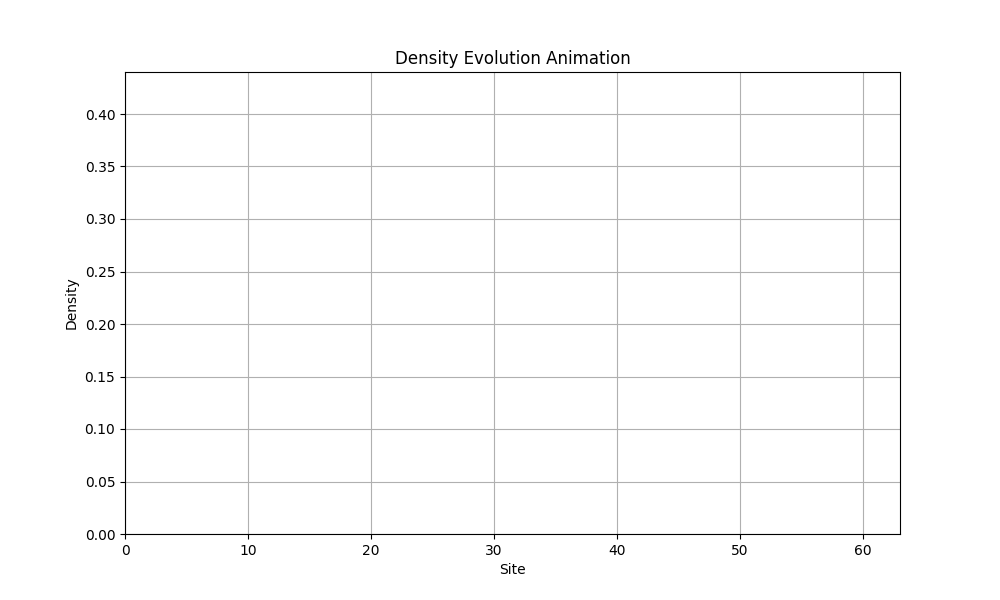

In [31]:
%matplotlib widget
anim = animate_density_evolution(filename, interval=100)